In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator
import pickle 
import time

from qiskit.algorithms.gradients import ParamShiftEstimatorGradient

In [2]:
VQE_training = True
n_qubits=4
j_coupling=1
g_coupling=1.5
n_rep_VQEansatz=1

def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x,label='ground state energy')
    #plt.show()


In [3]:
h_coupling=j_coupling*1
qr_VQE = QuantumRegister(n_qubits)
qc_VQE = QuantumCircuit(qr_VQE)
ansatz_VQE =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz,parameter_prefix='w')
qc_VQE.h(qr_VQE)
qc_VQE.compose(ansatz_VQE, inplace=True)  
#qc_VQE.decompose().draw('mpl')


In [4]:
observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])
for i in np.arange(1,n_qubits,1):
    observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
for i in range(n_qubits-1):
    observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))
    
eigenValues=np.linalg.eig(observable.to_matrix())[0]
eigenValues.sort()
groundEnergy=eigenValues[0]
print("ground state energy =", groundEnergy)


qnn_VQE=EstimatorQNN(
        estimator=Estimator(options={"shots":1e10}),
        circuit=qc_VQE,
        weight_params=ansatz_VQE.parameters,
        observables=observable
        )    

ground state energy = (-4.758770483143634+0j)


In [5]:
np.random.seed(seed=1000)
init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi
weights=init_weights

estimator = Estimator()
job=estimator.run(circuits=[qc_VQE], observables=[observable]
                          , parameter_values=[weights])

gradEstimator= ParamShiftEstimatorGradient(estimator )
gradJob=gradEstimator.run(circuits=[qc_VQE], observables=[observable]
                          , parameter_values=[weights])

In [6]:
job.result()


EstimatorResult(values=array([1.87781008]), metadata=[{}])

In [7]:
gradJob.result().gradients

[array([ 1.46297466,  1.62437548, -0.18793862, -0.17248494, -0.77269837,
        -1.13375993, -1.21632448,  0.70481645])]

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum",instance="ibm-q-utokyo/internal/icepp-r5",token="92c86f4f7143bea1235c92973436c3108bed314b09a95f79fde8574cd647bd80567d55d69ea294942424f4808a1a2b8b6ef040af82a88d926a511a636cf6400f")
QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True,instance="ibm-q-utokyo/internal/icepp-r5", token="92c86f4f7143bea1235c92973436c3108bed314b09a95f79fde8574cd647bd80567d55d69ea294942424f4808a1a2b8b6ef040af82a88d926a511a636cf6400f", set_as_default=True)

# service = QiskitRuntimeService(channel="ibm_quantum",instance="utokyo-kawasaki/internal/icepp-r5",token="92c86f4f7143bea1235c92973436c3108bed314b09a95f79fde8574cd647bd80567d55d69ea294942424f4808a1a2b8b6ef040af82a88d926a511a636cf6400f")
# QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True,instance="utokyo-kawasaki/internal/icepp-r5", token="92c86f4f7143bea1235c92973436c3108bed314b09a95f79fde8574cd647bd80567d55d69ea294942424f4808a1a2b8b6ef040af82a88d926a511a636cf6400f", set_as_default=True)

#service = QiskitRuntimeService()

In [17]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator
from qiskit.providers.fake_provider import FakeManila

backend_realDevice=service.get_backend('ibmq_kolkata')

noise_model = NoiseModel.from_backend(backend_realDevice)

simulator = service.get_backend('ibmq_qasm_simulator')
simulator.set_options(noise_model=noise_model)

simulator_noNoise = service.get_backend('ibmq_qasm_simulator')

In [11]:
# Set options to include the noise model with error mitigation
options0= Options(resilience_level=0)
options1= Options(resilience_level=1)
#options.optimization_level = 0 # no optimization
#options.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

In [14]:
nEvents=1
nShots=2**14
print(nShots)
init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi

16384


HardWare

In [15]:
learning_rate=1e-1
weights=init_weights

loss_list=[]
jobs_list=[]
gradJobs_list=[]

with Session(service=service, backend=backend_realDevice) as session:
    estimator = Estimator(session=session,options=options0)
    for i in range(40):
        t_start=time.time()
        job=estimator.run(circuits=[qc_VQE], observables=[observable]
                          , parameter_values=[weights]
                          ,shots=nShots)


        gradEstimator= ParamShiftEstimatorGradient(estimator )
        gradJob=gradEstimator.run(circuits=[qc_VQE], observables=[observable]
                              , parameter_values=[weights]
                              ,shots=nShots)

        jobs_list.append(job)
        gradJobs_list.append(gradJob)
        
        print(job.job_id())
        print(gradJob.job_id())
        loss=job.result().values[0]
        loss_list.append(loss)
        weights=weights-learning_rate*gradJob.result().gradients[0]

        print("loss=",loss)
        print("time taken = ",time.time()-t_start)

cppytw31tcz0008mb7e0
b9c23bcf-503c-47e3-97bd-74dea26ee138
loss= 1.3714599609375
time taken =  144.99773120880127
cppyw081tcz0008mb7jg
91e82373-0a2b-4ae3-a1d7-89f94410f35a
loss= 0.615478515625
time taken =  73.68650913238525
cppywjtd7p30008hz0m0
d34a7320-638e-4b2c-bf79-88867750414e
loss= -0.17919921875
time taken =  73.43205380439758
cppyx54dmm10008rcca0
a65cea86-d5f9-4ac0-82f9-d37357002b63
loss= -0.9322509765625
time taken =  74.02550911903381
cppyxqpdmm10008rccag
65016edc-8bd0-4140-8767-24bd9f75837f
loss= -1.658935546875
time taken =  76.93083500862122
cppyyasdmm10008rccc0
682e1f95-5171-455b-a826-dff0f6795239
loss= -2.21923828125
time taken =  73.68592405319214
cppyyxbsp83g008y9w90
4615159a-f720-4275-b00a-0bec5ca375ca
loss= -2.6451416015625
time taken =  79.47409105300903
cppyzh61tcz0008mb7zg
8dd6dd29-e2c6-4658-b287-51f299fce04f
loss= -2.95751953125
time taken =  73.69987392425537
cppz03g9nad00083jnmg
80a9cabe-387a-4be5-a28b-72544429eaac
loss= -3.198974609375
time taken =  73.43439912

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 432x288 with 0 Axes>

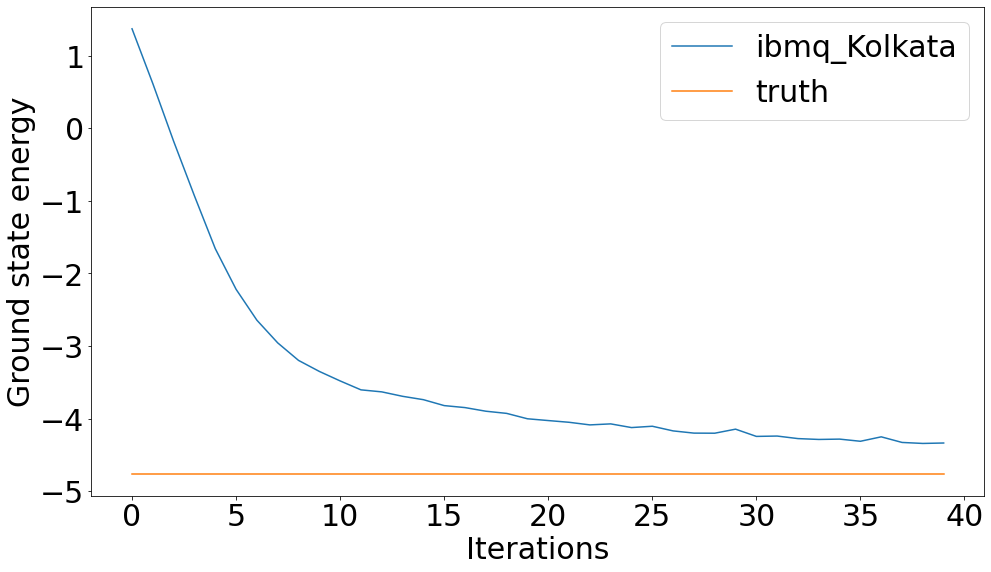

In [16]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
plt.plot(range(len(loss_list)),loss_list,label='ibmq_Kolkata')
plt.plot(range(len(loss_list)),groundEnergy*np.ones(len(loss_list)),label='truth')
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Ground state energy',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)

simulator

In [18]:
learning_rate=1e-1
weights=init_weights

loss_list_noise=[]
jobs_list_noise=[]
gradJobs_list_noise=[]

with Session(service=service, backend=simulator ) as session:
    estimator = Estimator(session=session,options=options0)
    for i in range(50):
        t_start=timte.time()
        job=estimator.run(circuits=[qc_VQE], observables=[observable]
                          , parameter_values=[weights]
                          ,shots=nShots)


        gradEstimator= ParamShiftEstimatorGradient(estimator )
        gradJob=gradEstimator.run(circuits=[qc_VQE], observables=[observable]
                              , parameter_values=[weights]
                              ,shots=nShots)

        jobs_list_noise.append(job)
        gradJobs_list_noise.append(gradJob)
        loss=job.result().values[0]
        loss_list_noise.append(loss)
        weights=weights-learning_rate*gradJob.result().gradients[0]

        print("loss=",loss)
        print("time taken = ",time.time()-t_start)

loss= 1.6588134765625
time taken =  532.4655621051788
loss= 0.763671875
time taken =  538.2360200881958
loss= -0.2281494140625
time taken =  543.9353792667389
loss= -1.200927734375
time taken =  549.4104340076447
loss= -1.96240234375
time taken =  555.5455889701843
loss= -2.553466796875
time taken =  561.2811992168427
loss= -2.9443359375
time taken =  566.3607642650604
loss= -3.2427978515625
time taken =  572.0304419994354
loss= -3.4407958984375
time taken =  578.2578461170197
loss= -3.5877685546875
time taken =  583.9956662654877
loss= -3.71728515625
time taken =  589.5686120986938
loss= -3.779541015625
time taken =  594.9214141368866
loss= -3.8582763671875
time taken =  600.6072413921356
loss= -3.9425048828125
time taken =  608.5582621097565
loss= -4.0194091796875
time taken =  614.0707292556763
loss= -4.0394287109375
time taken =  619.8082492351532
loss= -4.0975341796875
time taken =  625.3530201911926
loss= -4.136962890625
time taken =  631.1735441684723
loss= -4.1844482421875
time

In [ ]:
learning_rate=1e-1
weights=init_weights

loss_list_noNoise=[]
jobs_list_noNoise=[]
gradJobs_list_noNoise=[]

with Session(service=service, backend=simulator_noNoise ) as session:
    estimator = Estimator(session=session,options=options0)
    for i in range(50):
        t_start=time.time()
        job=estimator.run(circuits=[qc_VQE], observables=[observable]
                          , parameter_values=[weights]
                          ,shots=nShots)


        gradEstimator= ParamShiftEstimatorGradient(estimator )
        gradJob=gradEstimator.run(circuits=[qc_VQE], observables=[observable]
                              , parameter_values=[weights]
                              ,shots=nShots)

        jobs_list_noNoise.append(job)
        gradJobs_list_noNoise.append(gradJob)
        loss=job.result().values[0]
        loss_list_noNoise.append(loss)
        weights=weights-learning_rate*gradJob.result().gradients[0]

        print("loss=",loss)
        print("time taken = ",time.time()-t_start)

loss= 1.7333984375
time taken =  16.431186199188232
loss= 0.764892578125
time taken =  5.4829089641571045
loss= -0.2520751953125
time taken =  5.968378305435181
loss= -1.2156982421875
time taken =  5.985330820083618
loss= -1.9805908203125
time taken =  123.95793104171753
loss= -2.5709228515625
time taken =  6.13530707359314
loss= -2.9576416015625
time taken =  5.729377031326294
loss= -3.2713623046875
time taken =  5.047143936157227
loss= -3.455078125
time taken =  5.659081935882568
loss= -3.608154296875
time taken =  5.55674409866333
loss= -3.7012939453125
time taken =  5.87424898147583
loss= -3.8060302734375
time taken =  5.703405141830444
loss= -3.8448486328125
time taken =  5.45871376991272
loss= -3.9326171875
time taken =  5.320739269256592
loss= -3.9859619140625
time taken =  170.43577218055725
loss= -4.052734375
time taken =  5.47694993019104
loss= -4.0911865234375
time taken =  5.695282936096191
loss= -4.1268310546875
time taken =  5.526566982269287
loss= -4.21142578125
time tak

In [ ]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
plt.plot(range(len(loss_list)),loss_list,label='ibmq_Kolkata')
plt.plot(range(len(loss_list_noise)),loss_list,label='simulator (Kolkata noise model)')
plt.plot(range(len(loss_list_noNoise)),loss_list_noNoise,label='simulator (No noise)')
plt.plot(range(len(loss_list)),groundEnergy*np.ones(len(loss_list)),label='truth')
plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Ground state energy',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)